# Prompt-to-Prompt with Latent Diffusion

### Imports, constants, loading model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd path_to_your_project
!pwd

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from diffusers import DiffusionPipeline
%load_ext autoreload
%autoreload 2
import prompt2prompt as ptp

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model_id = "CompVis/ldm-text2im-large-256"
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 5.
MAX_NUM_WORDS = 77
# load model and scheduler
ldm = DiffusionPipeline.from_pretrained(model_id).to(device)
tokenizer = ldm.tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/2.95k [00:00<?, ?B/s]

images/squirrel-1.png:   0%|          | 0.00/108k [00:00<?, ?B/s]

images/squirrel-0.png:   0%|          | 0.00/118k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

images/squirrel-3.png:   0%|          | 0.00/80.8k [00:00<?, ?B/s]

images/squirrel-2.png:   0%|          | 0.00/98.2k [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

bert/config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

tokenizer/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/713 [00:00<?, ?B/s]

vqvae/config.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.49G [00:00<?, ?B/s]

{'cross_attention_dim'} was not found in config. Values will be initialized to default values.
{'set_alpha_to_one'} was not found in config. Values will be initialized to default values.


## Baselines

### Baseline: Cross-Attention Visualization (and initialization of "latent")

  0%|          | 0/50 [00:00<?, ?it/s]

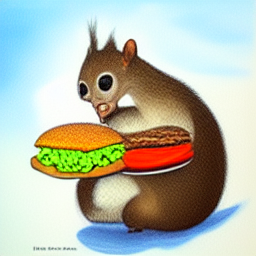

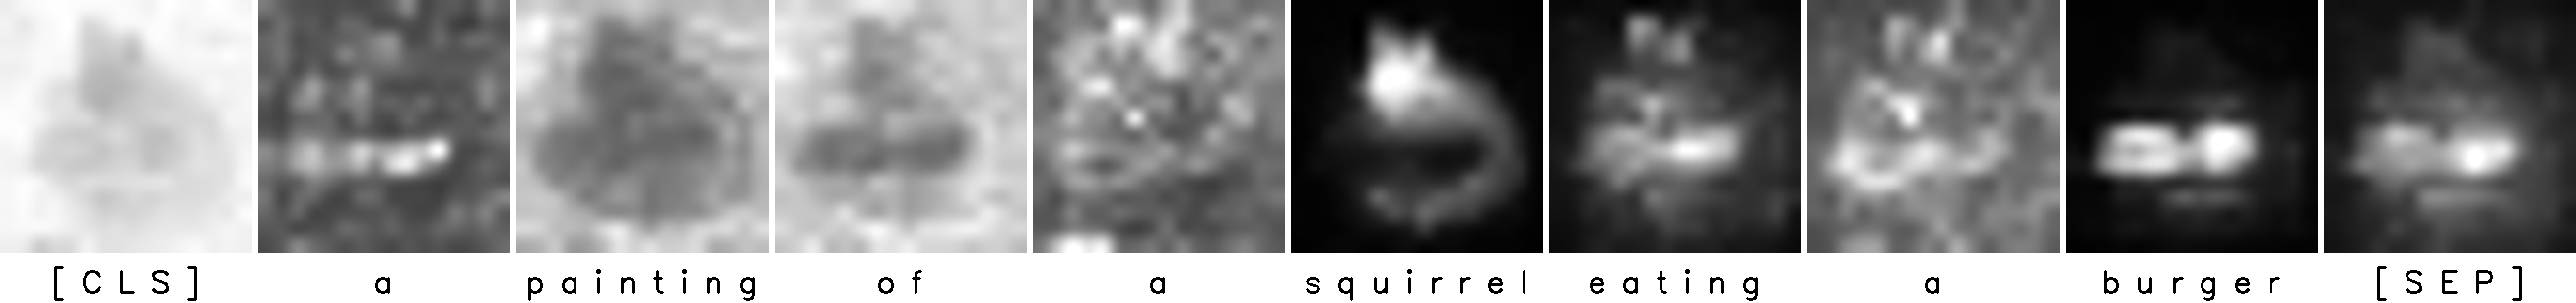

In [ ]:
g_cpu = torch.Generator().manual_seed(1024)
prompts = ["A painting of a squirrel eating a burger"]
# Use AttentionStore to keep track of all the attention weights
controller = ptp.AttentionStore()
# Get the base attention (store in "latent") from the first prompt
images, latent = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=None, generator=g_cpu)
# Use AttentionStore to visualize the cross-attention
ptp.show_cross_attention(tokenizer, prompts, controller, res=16, from_where=["up", "down"])

### Baseline: No Attention Controller

results without prompt-to-prompt


  0%|          | 0/50 [00:00<?, ?it/s]

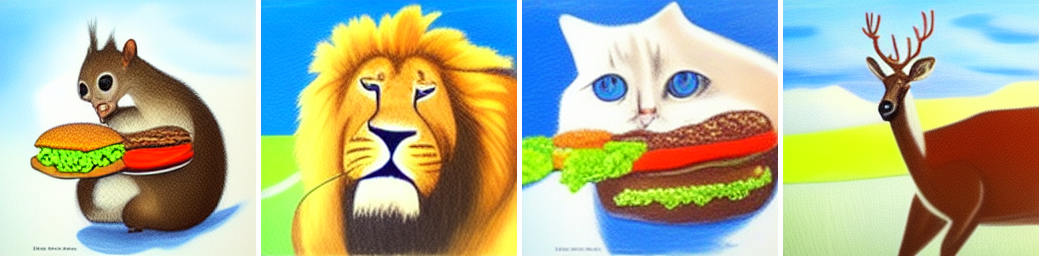

In [ ]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a lion eating a burger",
           "A painting of a cat eating a burger",
           "A painting of a deer eating a burger",
          ]
print("results without prompt-to-prompt")
controller = ptp.EmptyControl()
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)

## Prompt-to-Prompt

(Note: Before you run any of the cells in this section, you must first run the  'Baseline: Cross Attention Visualization' cell above to initialize the variable "latent".)


### Prompt-to-Prompt: Word-swap

results with prompt-to-prompt
(10, 10)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[101, 1037, 4169, 1997, 1037, 18197, 5983, 1037, 15890, 102]
[101, 1037, 4169, 1997, 1037, 7006, 5983, 1037, 15890, 102]
(10, 10)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[101, 1037, 4169, 1997, 1037, 18197, 5983, 1037, 15890, 102]
[101, 1037, 4169, 1997, 1037, 4937, 5983, 1037, 15890, 102]
(10, 10)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1

  0%|          | 0/50 [00:00<?, ?it/s]

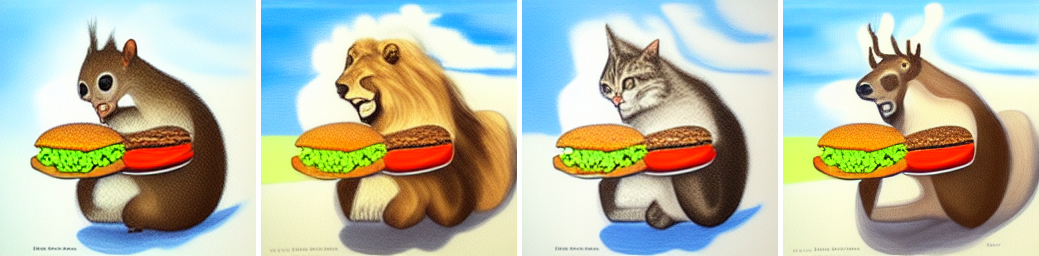

In [ ]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a lion eating a burger",
           "A painting of a cat eating a burger",
           "A painting of a deer eating a burger",
          ]
print("results with prompt-to-prompt")
controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps=.8, self_replace_steps=.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)

### Prompt-to-Prompt: Modify Cross-Attention injection #steps for specific words
Next, we can reduce the restriction on our lion by reducing the number of cross-attention injection with respect to the replacement words.

(10, 10)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[101, 1037, 4169, 1997, 1037, 18197, 5983, 1037, 15890, 102]
[101, 1037, 4169, 1997, 1037, 3899, 5983, 1037, 15890, 102]


  0%|          | 0/50 [00:00<?, ?it/s]

(10, 10)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[101, 1037, 4169, 1997, 1037, 18197, 5983, 1037, 15890, 102]
[101, 1037, 4169, 1997, 1037, 3899, 5983, 1037, 15890, 102]


  0%|          | 0/50 [00:00<?, ?it/s]

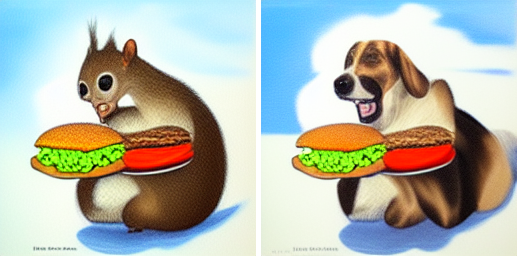

(10, 10)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[101, 1037, 4169, 1997, 1037, 18197, 5983, 1037, 15890, 102]
[101, 1037, 4169, 1997, 1037, 3899, 5983, 1037, 15890, 102]


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a dog eating a burger",
          ]
controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps={"default_": 1., "dog": 0.9}, self_replace_steps=0.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)
controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps={"default_": 1., "dog": 0.5}, self_replace_steps=0.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)
controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps={"default_": 1., "dog": 0.1}, self_replace_steps=0.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)

### Prompt-to-Prompt: Local Edit
Lastly, if we want to only replace the burger, we can apply a local edit with respect to to the replacement words.

(10, 10)
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
[101, 1037, 4169, 1997, 1037, 18197, 5983, 1037, 15890, 102]
[101, 1037, 4169, 1997, 1037, 18197, 5983, 1037, 5869, 25440, 102]
(10, 10)
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.     

  0%|          | 0/50 [00:00<?, ?it/s]

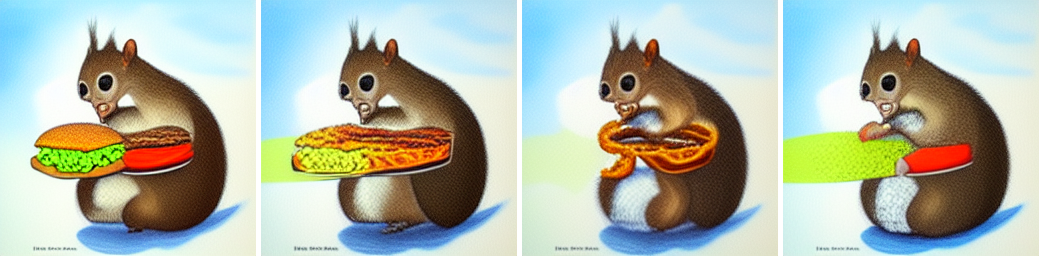

In [ ]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a squirrel eating a lasagne",
           "A painting of a squirrel eating a pretzel",
           "A painting of a squirrel eating a sushi",
          ]

controller = ptp.AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps={"default_": 1., "lasagne": .2, "pretzel": .2, "sushi": .2}, self_replace_steps=0.2)
_ = ptp.run_and_display(prompts, controller, ldm, num_diffusion_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, latent=latent)